In [1]:
!pip install mediapipe --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-cloud-bigtable 2.32.0 requires google-api-core[grpc]<3.0.0,>=2.17.0, but you have google-api-core 1.34.1 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes

In [4]:
# ==============================================
# 🎯 Valence–Arousal & Emotion Proxies from Mediapipe FaceMesh (no 468D saving)
# ==============================================
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
from collections import deque

# ---------- USER SETTINGS ----------
BASE_DIR = "/kaggle/input/videoss/VIDEO"      # ✅ your top-level folder name
OUTPUT_DIR = "./mediapipe_output"     # folder to save emotion CSVs
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Optional: exponential moving average smoothing for features/VA (0=no smoothing)
SMOOTH_ALPHA = 0.2

# ---------- Mediapipe Initialization ----------
mp_face_mesh = mp.solutions.face_mesh

# ---- Landmark indices (MediaPipe 468) ----
L_EYE_OUT, L_EYE_IN = 33, 133
R_EYE_OUT, R_EYE_IN = 362, 263
L_EYE_TOP, L_EYE_BOT = 159, 145
R_EYE_TOP, R_EYE_BOT = 386, 374
MOUTH_LEFT, MOUTH_RIGHT = 61, 291
MOUTH_TOP, MOUTH_BOT = 13, 14
BROW_IN_L, BROW_IN_R = 70, 300
EYE_REF_L, EYE_REF_R = 159, 386

def _dist(p, q):
    return np.linalg.norm(p - q)

def _ema_update(prev, new, alpha):
    if prev is None:
        return new
    return alpha * new + (1 - alpha) * prev

def extract_emotion_features_per_video(video_path, participant_id, camera_name):
    cap = cv2.VideoCapture(video_path)
    file_label = f"{participant_id}_{camera_name}"
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    print(f"🎥 Processing {file_label} at {fps:.2f} FPS")

    frames_data = []

    with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as face_mesh:

        frame_idx = 0
        blink_window = deque(maxlen=5)
        ema_state = None

        while cap.isOpened():
            ok, frame = cap.read()
            if not ok:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(frame_rgb)

            if not results.multi_face_landmarks:
                frame_idx += 1
                continue

            lms = results.multi_face_landmarks[0].landmark
            pts = np.array([[lm.x, lm.y, lm.z] for lm in lms], dtype=np.float32)
            centroid = pts.mean(axis=0, keepdims=True)
            pts_c = pts - centroid
            eye_vec = pts_c[L_EYE_OUT] - pts_c[R_EYE_IN]
            iod = np.linalg.norm(eye_vec) or 1e-6
            pts_n = pts_c / iod

            def P(i): return pts_n[i]

            eye_w_L = _dist(P(L_EYE_OUT)[:2], P(L_EYE_IN)[:2])
            eye_h_L = _dist(P(L_EYE_TOP)[:2], P(L_EYE_BOT)[:2])
            eye_open_L = eye_h_L / (eye_w_L + 1e-6)
            eye_w_R = _dist(P(R_EYE_OUT)[:2], P(R_EYE_IN)[:2])
            eye_h_R = _dist(P(R_EYE_TOP)[:2], P(R_EYE_BOT)[:2])
            eye_open_R = eye_h_R / (eye_w_R + 1e-6)
            eye_open = 0.5 * (eye_open_L + eye_open_R)

            mouth_w = _dist(P(MOUTH_LEFT)[:2], P(MOUTH_RIGHT)[:2])
            mouth_h = _dist(P(MOUTH_TOP)[:2], P(MOUTH_BOT)[:2])
            smile_intensity = mouth_w
            mouth_open = mouth_h

            brow_furrow = _dist(P(BROW_IN_L)[:2], P(BROW_IN_R)[:2])
            brow_raise_L = abs(P(BROW_IN_L)[1] - P(EYE_REF_L)[1])
            brow_raise_R = abs(P(BROW_IN_R)[1] - P(EYE_REF_R)[1])
            brow_raise = 0.5 * (brow_raise_L + brow_raise_R)
            lip_press = max(0.0, 1.0 - (mouth_open / (mouth_open + 0.15)))

            blink_window.append(eye_open)
            blink = 1 if (len(blink_window) == blink_window.maxlen and np.mean(blink_window) < 0.18) else 0

            raw = {
                "frame": frame_idx, "fps": fps,
                "eye_open": eye_open,
                "smile_intensity": smile_intensity,
                "mouth_open": mouth_open,
                "brow_raise": brow_raise,
                "brow_furrow": brow_furrow,
                "lip_press": lip_press,
                "blink": blink
            }

            if SMOOTH_ALPHA > 0:
                if ema_state is None:
                    ema_state = raw.copy()
                else:
                    for k in ["eye_open","smile_intensity","mouth_open","brow_raise","brow_furrow","lip_press"]:
                        ema_state[k] = _ema_update(ema_state[k], raw[k], SMOOTH_ALPHA)
                    ema_state["frame"], ema_state["fps"], ema_state["blink"] = raw["frame"], raw["fps"], raw["blink"]
                frames_data.append(ema_state.copy())
            else:
                frames_data.append(raw)

            frame_idx += 1

    cap.release()
    if not frames_data:
        return pd.DataFrame(columns=["frame","fps","valence","arousal"])

    feat_df = pd.DataFrame(frames_data)
    cont_cols = ["eye_open","smile_intensity","mouth_open","brow_raise","brow_furrow","lip_press"]
    norm_df = feat_df.copy()
    for c in cont_cols:
        cmin, cmax = norm_df[c].min(), norm_df[c].max()
        norm_df[c] = 0.5 if cmax - cmin < 1e-9 else (norm_df[c] - cmin) / (cmax - cmin)

    valence = (
        0.65 * norm_df["smile_intensity"]
        - 0.25 * (1.0 - norm_df["brow_furrow"])
        - 0.10 * norm_df["lip_press"]
    )
    arousal = 0.55 * norm_df["eye_open"] + 0.45 * norm_df["mouth_open"]

    engagement_score = np.clip(0.6 * norm_df["eye_open"] + 0.4 * norm_df["mouth_open"], 0, 1)
    frustration_score = np.clip(0.6 * (1.0 - norm_df["brow_furrow"]) + 0.4 * norm_df["lip_press"], 0, 1)
    excitement_score = np.clip(0.6 * valence + 0.6 * arousal, 0, 1)

    out = pd.DataFrame({
        "frame": feat_df["frame"].astype(int),
        "fps": feat_df["fps"],
        "valence": np.clip(valence, 0, 1),
        "arousal": np.clip(arousal, 0, 1),
        "smile_intensity": norm_df["smile_intensity"],
        "mouth_open": norm_df["mouth_open"],
        "eye_open": norm_df["eye_open"],
        "brow_raise": norm_df["brow_raise"],
        "brow_furrow": 1.0 - norm_df["brow_furrow"],
        "lip_press": norm_df["lip_press"],
        "blink": feat_df["blink"],
        "engagement_score": engagement_score,
        "frustration_score": frustration_score,
        "excitement_score": excitement_score
    })
    return out

def process_all_pairs():
    for participant_folder in sorted(os.listdir(BASE_DIR)):
        participant_path = os.path.join(BASE_DIR, participant_folder)
        if not os.path.isdir(participant_path):
            continue

        print(f"\n👤 Processing participant: {participant_folder}")
        for cam in ["camera1", "camera2"]:
            video_path = os.path.join(participant_path, f"{cam}_output.mp4")
            if not os.path.exists(video_path):
                print(f"⚠️ Missing {cam}_output.mp4 for {participant_folder}")
                continue

            df = extract_emotion_features_per_video(video_path, participant_folder, cam)
            out_csv = os.path.join(OUTPUT_DIR, f"{participant_folder}_{cam}_emotions.csv")
            df.to_csv(out_csv, index=False)
            print(f"💾 Saved: {out_csv} ({len(df)} frames)")

if __name__ == "__main__":
    process_all_pairs()
    print("\n✅ All 17 participant-camera pairs processed successfully!")



👤 Processing participant: p_01
🎥 Processing p_01_camera1 at 15.00 FPS


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1762940632.093780     144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940632.118838     143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940632.122871     143 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


💾 Saved: ./mediapipe_output/p_01_camera1_emotions.csv (8812 frames)
🎥 Processing p_01_camera2 at 15.00 FPS


W0000 00:00:1762940689.047465     153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940689.070485     155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_01_camera2_emotions.csv (8886 frames)

👤 Processing participant: p_02
🎥 Processing p_02_camera1 at 15.00 FPS


W0000 00:00:1762940745.203731     162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940745.226414     162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_02_camera1_emotions.csv (8875 frames)
🎥 Processing p_02_camera2 at 15.00 FPS


W0000 00:00:1762940801.704346     169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940801.727779     170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_02_camera2_emotions.csv (8694 frames)

👤 Processing participant: p_03
🎥 Processing p_03_camera1 at 15.00 FPS


W0000 00:00:1762940858.898995     178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940858.921807     179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_03_camera1_emotions.csv (8871 frames)
🎥 Processing p_03_camera2 at 15.00 FPS


W0000 00:00:1762940915.727813     186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940915.749068     187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_03_camera2_emotions.csv (8970 frames)

👤 Processing participant: p_04
🎥 Processing p_04_camera1 at 15.00 FPS


W0000 00:00:1762940972.864759     196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762940972.880558     195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_04_camera1_emotions.csv (8881 frames)
🎥 Processing p_04_camera2 at 15.00 FPS


W0000 00:00:1762941029.600560     208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941029.622874     209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_04_camera2_emotions.csv (8809 frames)

👤 Processing participant: p_05
🎥 Processing p_05_camera1 at 15.00 FPS


W0000 00:00:1762941085.926162     217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941085.944795     217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_05_camera1_emotions.csv (8870 frames)
🎥 Processing p_05_camera2 at 15.00 FPS


W0000 00:00:1762941143.360410     226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941143.378188     227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_05_camera2_emotions.csv (8644 frames)

👤 Processing participant: p_06
🎥 Processing p_06_camera1 at 15.00 FPS


W0000 00:00:1762941199.854494     234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941199.869184     235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_06_camera1_emotions.csv (8784 frames)
🎥 Processing p_06_camera2 at 15.00 FPS


W0000 00:00:1762941256.925950     241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941256.941031     243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_06_camera2_emotions.csv (8826 frames)

👤 Processing participant: p_07
🎥 Processing p_07_camera1 at 15.00 FPS


W0000 00:00:1762941313.993978     250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941314.009653     251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_07_camera1_emotions.csv (8924 frames)
🎥 Processing p_07_camera2 at 15.00 FPS


W0000 00:00:1762941370.815612     258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941370.833849     259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_07_camera2_emotions.csv (8988 frames)

👤 Processing participant: p_08
🎥 Processing p_08_camera1 at 15.00 FPS


W0000 00:00:1762941427.634053     266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941427.657501     267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_08_camera1_emotions.csv (8862 frames)
🎥 Processing p_08_camera2 at 15.00 FPS


W0000 00:00:1762941484.611540     275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941484.626117     276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_08_camera2_emotions.csv (8733 frames)

👤 Processing participant: p_09
🎥 Processing p_09_camera1 at 15.00 FPS


W0000 00:00:1762941541.472628     281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941541.491104     283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_09_camera1_emotions.csv (8932 frames)
🎥 Processing p_09_camera2 at 15.00 FPS


W0000 00:00:1762941598.632261     290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941598.649004     291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_09_camera2_emotions.csv (8817 frames)

👤 Processing participant: p_10
🎥 Processing p_10_camera1 at 15.00 FPS


W0000 00:00:1762941655.130916     298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941655.147883     298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_10_camera1_emotions.csv (8982 frames)
🎥 Processing p_10_camera2 at 15.00 FPS


W0000 00:00:1762941711.904088     306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941711.920715     307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_10_camera2_emotions.csv (8574 frames)

👤 Processing participant: p_11
🎥 Processing p_11_camera1 at 15.00 FPS


W0000 00:00:1762941768.563500     314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941768.578993     315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_11_camera1_emotions.csv (8890 frames)
🎥 Processing p_11_camera2 at 15.00 FPS


W0000 00:00:1762941824.450628     322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941824.470136     323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_11_camera2_emotions.csv (8859 frames)

👤 Processing participant: p_12
🎥 Processing p_12_camera1 at 15.00 FPS


W0000 00:00:1762941881.415313     330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941881.441115     331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_12_camera1_emotions.csv (8678 frames)
🎥 Processing p_12_camera2 at 15.00 FPS


W0000 00:00:1762941937.369043     338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941937.383086     339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_12_camera2_emotions.csv (8788 frames)

👤 Processing participant: p_13
🎥 Processing p_13_camera1 at 15.00 FPS


W0000 00:00:1762941993.907907     346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762941993.924290     347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_13_camera1_emotions.csv (7516 frames)
🎥 Processing p_13_camera2 at 15.00 FPS


W0000 00:00:1762942049.113876     356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942049.131637     355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_13_camera2_emotions.csv (8355 frames)

👤 Processing participant: p_14
🎥 Processing p_14_camera1 at 15.00 FPS


W0000 00:00:1762942104.290521     362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942104.310955     363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_14_camera1_emotions.csv (8775 frames)
🎥 Processing p_14_camera2 at 15.00 FPS


W0000 00:00:1762942162.341375     369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942162.357082     371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_14_camera2_emotions.csv (9115 frames)

👤 Processing participant: p_15
🎥 Processing p_15_camera1 at 15.00 FPS


W0000 00:00:1762942220.077992     379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942220.097221     377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_15_camera1_emotions.csv (8962 frames)
🎥 Processing p_15_camera2 at 15.00 FPS


W0000 00:00:1762942276.951849     387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942276.968742     385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_15_camera2_emotions.csv (8990 frames)

👤 Processing participant: p_16
🎥 Processing p_16_camera1 at 15.00 FPS


W0000 00:00:1762942333.648817     395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942333.670838     395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_16_camera1_emotions.csv (8957 frames)
🎥 Processing p_16_camera2 at 15.00 FPS


W0000 00:00:1762942391.339817     401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942391.358315     402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_16_camera2_emotions.csv (8922 frames)

👤 Processing participant: p_17
🎥 Processing p_17_camera1 at 15.00 FPS


W0000 00:00:1762942448.477094     410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942448.500263     411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_17_camera1_emotions.csv (8843 frames)
🎥 Processing p_17_camera2 at 15.00 FPS


W0000 00:00:1762942505.660055     420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762942505.682356     420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


💾 Saved: ./mediapipe_output/p_17_camera2_emotions.csv (8706 frames)

✅ All 17 participant-camera pairs processed successfully!


In [5]:
!zip -r mediapipe_output.zip mediapipe_output

  adding: mediapipe_output/ (stored 0%)
  adding: mediapipe_output/p_17_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_02_camera1_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_09_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_16_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_01_camera1_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_05_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_11_camera1_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_04_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_16_camera1_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_03_camera1_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_07_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_05_camera1_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_06_camera2_emotions.csv (deflated 55%)
  adding: mediapipe_output/p_08_camera1_emotions.csv (deflated 55%)
  adding

✅ Loaded 8812 frames from ./mediapipe_output/p_01_camera1_emotions.csv


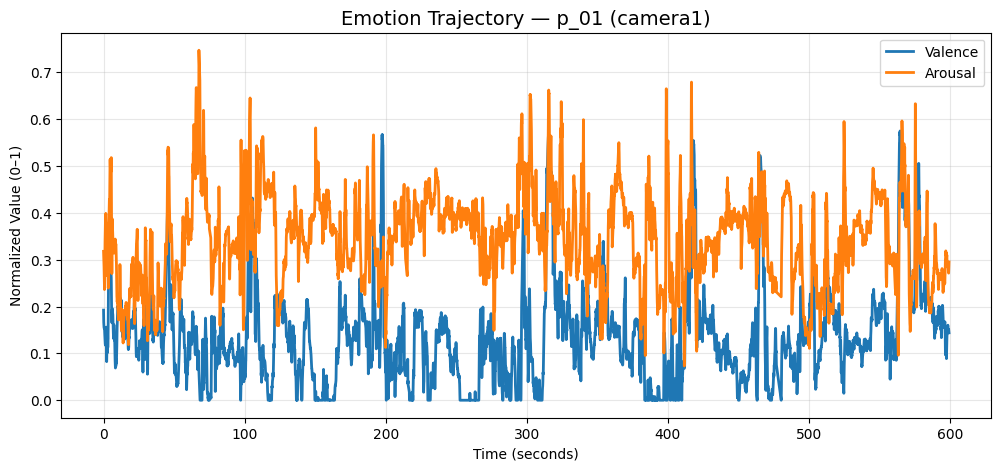

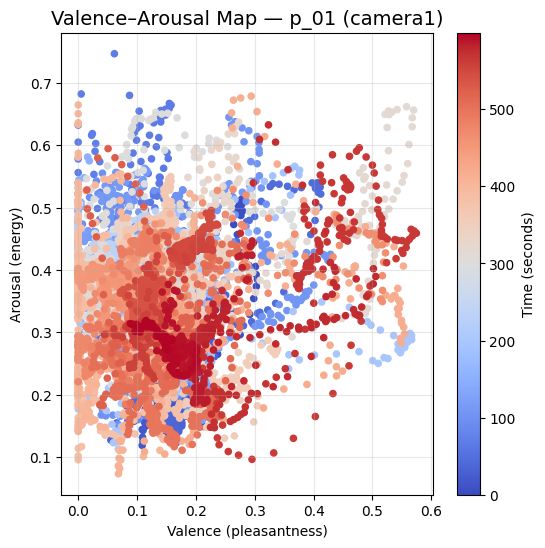

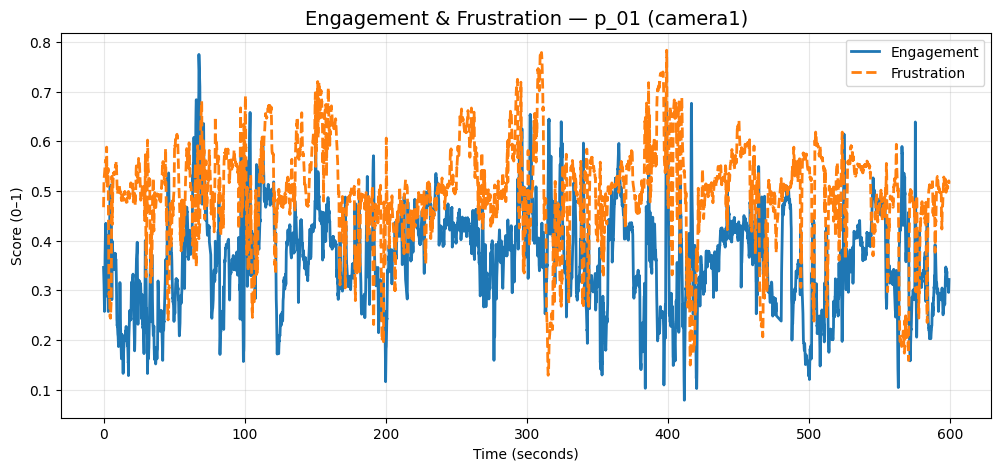

In [7]:
# ==============================================
# 🎬 Emotion Visualization: Valence–Arousal Timeline and Scatter
# ==============================================
import pandas as pd
import matplotlib.pyplot as plt
import os

# Folder where your CSVs were saved
OUTPUT_DIR = "./mediapipe_output"

# Choose one example participant + camera (you can loop later)
participant_id = "p_01"
camera_name = "camera1"
csv_path = os.path.join(OUTPUT_DIR, f"{participant_id}_{camera_name}_emotions.csv")

# Load the per-frame emotion data
df = pd.read_csv(csv_path)
if df.empty:
    print("⚠️ CSV is empty — no frames detected.")
else:
    print(f"✅ Loaded {len(df)} frames from {csv_path}")

# Compute time in seconds from frame number and fps
df["time_sec"] = df["frame"] / df["fps"]

# ------------------------------------------------------
# 1️⃣ Timeline Plot: Valence and Arousal vs. Time
# ------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["time_sec"], df["valence"], label="Valence", linewidth=2)
plt.plot(df["time_sec"], df["arousal"], label="Arousal", linewidth=2)
plt.title(f"Emotion Trajectory — {participant_id} ({camera_name})", fontsize=14)
plt.xlabel("Time (seconds)")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------
# 2️⃣ Valence–Arousal Scatter Plot (2D Emotion Space)
# ------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(df["valence"], df["arousal"], c=df["time_sec"], cmap="coolwarm", s=20)
plt.title(f"Valence–Arousal Map — {participant_id} ({camera_name})", fontsize=14)
plt.xlabel("Valence (pleasantness)")
plt.ylabel("Arousal (energy)")
cbar = plt.colorbar()
cbar.set_label("Time (seconds)")
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------
# 3️⃣ Optional: Engagement and Frustration Timeline
# ------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["time_sec"], df["engagement_score"], label="Engagement", linewidth=2)
plt.plot(df["time_sec"], df["frustration_score"], label="Frustration", linewidth=2, linestyle="--")
plt.title(f"Engagement & Frustration — {participant_id} ({camera_name})", fontsize=14)
plt.xlabel("Time (seconds)")
plt.ylabel("Score (0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


✅ Loaded 8982 frames from ./mediapipe_output/p_10_camera1_emotions.csv


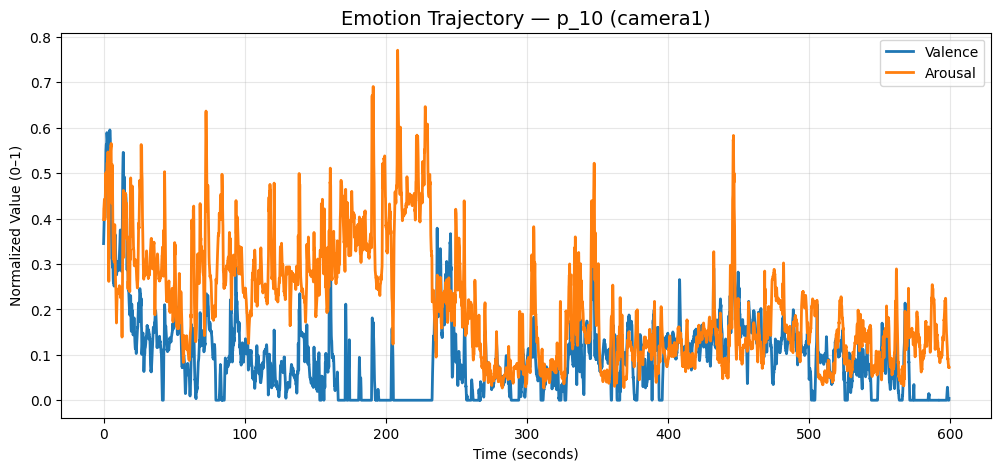

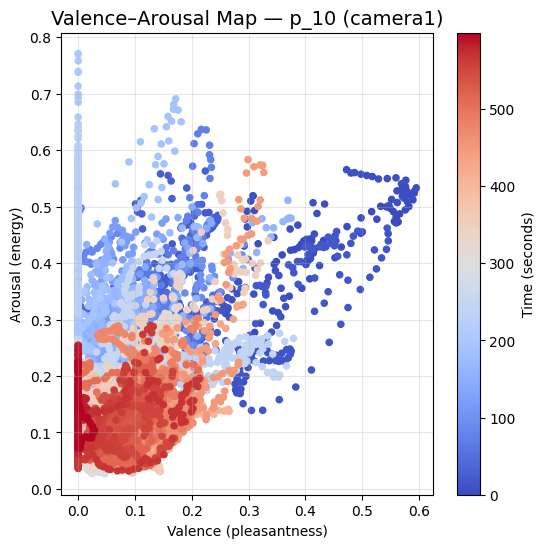

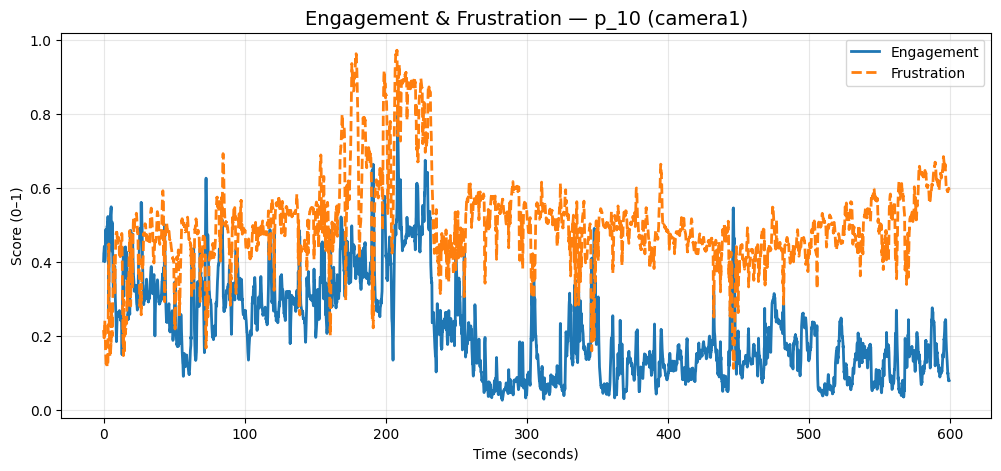

In [8]:
# ==============================================
# 🎬 Emotion Visualization: Valence–Arousal Timeline and Scatter
# ==============================================
import pandas as pd
import matplotlib.pyplot as plt
import os

# Folder where your CSVs were saved
OUTPUT_DIR = "./mediapipe_output"

# Choose one example participant + camera (you can loop later)
participant_id = "p_10"
camera_name = "camera1"
csv_path = os.path.join(OUTPUT_DIR, f"{participant_id}_{camera_name}_emotions.csv")

# Load the per-frame emotion data
df = pd.read_csv(csv_path)
if df.empty:
    print("⚠️ CSV is empty — no frames detected.")
else:
    print(f"✅ Loaded {len(df)} frames from {csv_path}")

# Compute time in seconds from frame number and fps
df["time_sec"] = df["frame"] / df["fps"]

# ------------------------------------------------------
# 1️⃣ Timeline Plot: Valence and Arousal vs. Time
# ------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["time_sec"], df["valence"], label="Valence", linewidth=2)
plt.plot(df["time_sec"], df["arousal"], label="Arousal", linewidth=2)
plt.title(f"Emotion Trajectory — {participant_id} ({camera_name})", fontsize=14)
plt.xlabel("Time (seconds)")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------
# 2️⃣ Valence–Arousal Scatter Plot (2D Emotion Space)
# ------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(df["valence"], df["arousal"], c=df["time_sec"], cmap="coolwarm", s=20)
plt.title(f"Valence–Arousal Map — {participant_id} ({camera_name})", fontsize=14)
plt.xlabel("Valence (pleasantness)")
plt.ylabel("Arousal (energy)")
cbar = plt.colorbar()
cbar.set_label("Time (seconds)")
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------
# 3️⃣ Optional: Engagement and Frustration Timeline
# ------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["time_sec"], df["engagement_score"], label="Engagement", linewidth=2)
plt.plot(df["time_sec"], df["frustration_score"], label="Frustration", linewidth=2, linestyle="--")
plt.title(f"Engagement & Frustration — {participant_id} ({camera_name})", fontsize=14)
plt.xlabel("Time (seconds)")
plt.ylabel("Score (0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
